# 机器学习纳米学位
## 监督学习
## 项目2: 为*CharityML*寻找捐献者

欢迎来到机器学习工程师纳米学位的第二个项目！在此文件中，有些示例代码已经提供给你，但你还需要实现更多的功能让项目成功运行。除非有明确要求，你无须修改任何已给出的代码。以**'练习'**开始的标题表示接下来的代码部分中有你必须要实现的功能。每一部分都会有详细的指导，需要实现的部分也会在注释中以'TODO'标出。请仔细阅读所有的提示！

除了实现代码外，你还必须回答一些与项目和你的实现有关的问题。每一个需要你回答的问题都会以**'问题 X'**为标题。请仔细阅读每个问题，并且在问题后的**'回答'**文字框中写出完整的答案。我们将根据你对问题的回答和撰写代码所实现的功能来对你提交的项目进行评分。
>**提示：**Code 和 Markdown 区域可通过**Shift + Enter**快捷键运行。此外，Markdown可以通过双击进入编辑模式。

## 开始

在这个项目中，你将使用1994年美国人口普查收集的数据，选用几个监督学习算法以准确地建模被调查者的收入。然后，你将根据初步结果从中选择出最佳的候选算法，并进一步优化该算法以最好地建模这些数据。你的目标是建立一个能够准确地预测被调查者年收入是否超过50000美元的模型。这种类型的任务会出现在那些依赖于捐款而存在的非营利性组织。了解人群的收入情况可以帮助一个非营利性的机构更好地了解他们要多大的捐赠，或是否他们应该接触这些人。虽然我们很难直接从公开的资源中推断出一个人的一般收入阶层，但是我们可以（也正是我们将要做的）从其他的一些公开的可获得的资源中获得一些特征从而推断出该值。

这个项目的数据集来自[UCI机器学习知识库](https://archive.ics.uci.edu/ml/datasets/Census+Income)。这个数据集是由Ron Kohavi和Barry Becker在发表文章_"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_之后捐赠的，你可以在Ron Kohavi提供的[在线版本](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf)中找到这个文章。我们在这里探索的数据集相比于原有的数据集有一些小小的改变，比如说移除了特征`'fnlwgt'` 以及一些遗失的或者是格式不正确的记录。

----
## 探索数据
运行下面的代码单元以载入需要的Python库并导入人口普查数据。注意数据集的最后一列`'income'`将是我们需要预测的列（表示被调查者的年收入会大于或者是最多50,000美元），人口普查数据中的每一列都将是关于被调查者的特征。

In [121]:
# 为这个项目导入需要的库
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # 允许为DataFrame使用display()

# 导入附加的可视化代码visuals.py
import visuals as vs

# 为notebook提供更加漂亮的可视化
%matplotlib inline

# 导入人口普查数据
data = pd.read_csv("census.csv")

# 成功 - 显示第一条记录
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### 练习：数据探索
首先我们对数据集进行一个粗略的探索，我们将看看每一个类别里会有多少被调查者？并且告诉我们这些里面多大比例是年收入大于50,000美元的。在下面的代码单元中，你将需要计算以下量：

- 总的记录数量，`'n_records'`
- 年收入大于50,000美元的人数，`'n_greater_50k'`.
- 年收入最多为50,000美元的人数 `'n_at_most_50k'`.
- 年收入大于50,000美元的人所占的比例， `'greater_percent'`.

**提示：** 您可能需要查看上面的生成的表，以了解`'income'`条目的格式是什么样的。 

In [76]:
# TODO：总的记录数
n_records = data.shape[0]

# TODO：被调查者的收入大于$50,000的人数
n_greater_50k = data.loc[data['income'] == '>50K'].shape[0]

# TODO：被调查者的收入最多为$50,000的人数
n_at_most_50k = data.loc[data['income'] == '<=50K'].shape[0]

# TODO：被调查者收入大于$50,000所占的比例
greater_percent = 1.0 * n_greater_50k / n_records

# 打印结果
print ("Total number of records: {}".format(n_records))
print ("Individuals making more than $50,000: {}".format(n_greater_50k))
print ("Individuals making at most $50,000: {}".format(n_at_most_50k))
print ("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent*100))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## 准备数据
在数据能够被作为输入提供给机器学习算法之前，它经常需要被清洗，格式化，和重新组织 - 这通常被叫做**预处理**。幸运的是，对于这个数据集，没有我们必须处理的无效或丢失的条目，然而，由于某一些特征存在的特性我们必须进行一定的调整。这个预处理都可以极大地帮助我们提升几乎所有的学习算法的结果和预测能力。

### 获得特征和标签
`income` 列是我们需要的标签，记录一个人的年收入是否高于50K。 因此我们应该把他从数据中剥离出来，单独存放。

In [77]:
# 将数据切分成特征和对应的标签
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

### 转换倾斜的连续特征

一个数据集有时可能包含至少一个靠近某个数字的特征，但有时也会有一些相对来说存在极大值或者极小值的不平凡分布的的特征。算法对这种分布的数据会十分敏感，并且如果这种数据没有能够很好地规一化处理会使得算法表现不佳。在人口普查数据集的两个特征符合这个描述：'`capital-gain'`和`'capital-loss'`。

运行下面的代码单元以创建一个关于这两个特征的条形图。请注意当前的值的范围和它们是如何分布的。

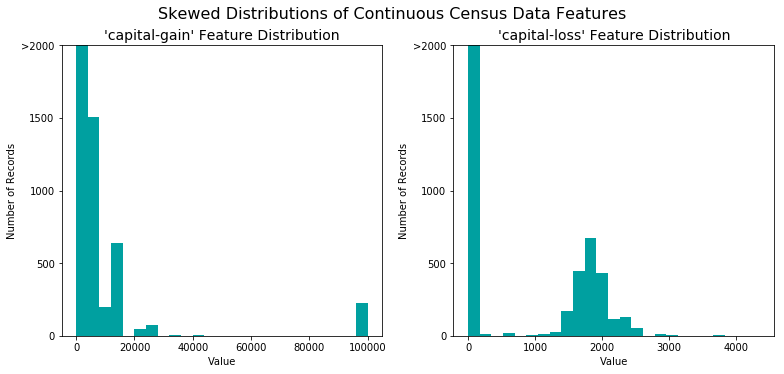

In [78]:
# 可视化 'capital-gain'和'capital-loss' 两个特征
vs.distribution(features_raw)

对于高度倾斜分布的特征如`'capital-gain'`和`'capital-loss'`，常见的做法是对数据施加一个<a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">对数转换</a>，将数据转换成对数，这样非常大和非常小的值不会对学习算法产生负面的影响。并且使用对数变换显著降低了由于异常值所造成的数据范围异常。但是在应用这个变换时必须小心：因为0的对数是没有定义的，所以我们必须先将数据处理成一个比0稍微大一点的数以成功完成对数转换。

运行下面的代码单元来执行数据的转换和可视化结果。再次，注意值的范围和它们是如何分布的。

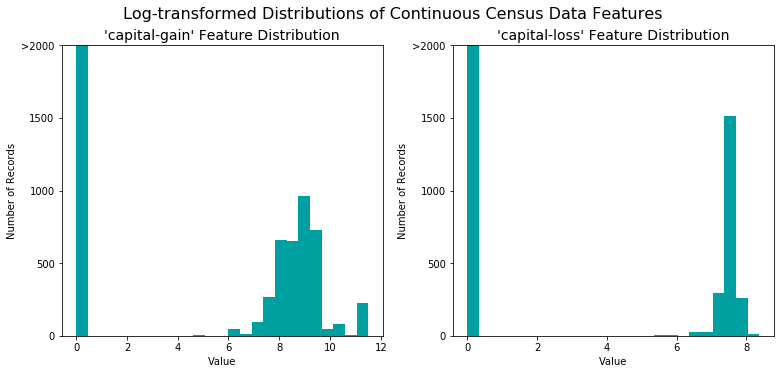

In [79]:
# 对于倾斜的数据使用Log转换
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# 可视化对数转换后 'capital-gain'和'capital-loss' 两个特征
vs.distribution(features_raw, transformed = True)

### 规一化数字特征
除了对于高度倾斜的特征施加转换，对数值特征施加一些形式的缩放通常会是一个好的习惯。在数据上面施加一个缩放并不会改变数据分布的形式（比如上面说的'capital-gain' or 'capital-loss'）；但是，规一化保证了每一个特征在使用监督学习器的时候能够被平等的对待。注意一旦使用了缩放，观察数据的原始形式不再具有它本来的意义了，就像下面的例子展示的。

运行下面的代码单元来规一化每一个数字特征。我们将使用[`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)来完成这个任务。

In [80]:
from sklearn.preprocessing import MinMaxScaler

# 初始化一个 scaler，并将它施加到特征上
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# 显示一个经过缩放的样例记录
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### 练习：数据预处理

从上面的**数据探索**中的表中，我们可以看到有几个属性的每一条记录都是非数字的。通常情况下，学习算法期望输入是数字的，这要求非数字的特征（称为类别变量）被转换。转换类别变量的一种流行的方法是使用**独热编码**方案。独热编码为每一个非数字特征的每一个可能的类别创建一个_“虚拟”_变量。例如，假设`someFeature`有三个可能的取值`A`，`B`或者`C`，。我们将把这个特征编码成`someFeature_A`, `someFeature_B`和`someFeature_C`.

| 特征X |          -          | 特征X_A | 特征X_B | 特征X_C |
| :-: |           -                | :-: | :-: | :-: |
|  B  | - | 0 | 1 | 0 |
|  C  | ----> 独热编码 ----> | 0 | 0 | 1 |
|  A  | - | 1 | 0 | 0 |

此外，对于非数字的特征，我们需要将非数字的标签`'income'`转换成数值以保证学习算法能够正常工作。因为这个标签只有两种可能的类别（"<=50K"和">50K"），我们不必要使用独热编码，可以直接将他们编码分别成两个类`0`和`1`，在下面的代码单元中你将实现以下功能：
 - 使用[`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies)对`'features_raw'`数据来施加一个独热编码。
 - 将目标标签`'income_raw'`转换成数字项。
   - 将"<=50K"转换成`0`；将">50K"转换成`1`。

In [81]:
# TODO：使用pandas.get_dummies()对'features_raw'数据进行独热编码
non_numerical = ['workclass', 'education_level', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
features_raw_part1 = features_raw.drop(non_numerical, axis=1)
features_raw_part2 = pd.get_dummies(features_raw[non_numerical])
features = pd.concat([features_raw_part1, features_raw_part2], axis=1)

POSITIVE, NEGATIVE = 1, 0
# TODO：将'income_raw'编码成数字值
def income_to_num(income):
    if income == '>50K':
        return POSITIVE
    else:
        return NEGATIVE
income = income_raw.apply(lambda x: income_to_num(x))

# 打印经过独热编码之后的特征数量
encoded = list(features.columns)
print ("{} total features after one-hot encoding.".format(len(encoded)))

# 移除下面一行的注释以观察编码的特征名字
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### 混洗和切分数据
现在所有的 _类别变量_ 已被转换成数值特征，而且所有的数值特征已被规一化。和我们一般情况下做的一样，我们现在将数据（包括特征和它们的标签）切分成训练和测试集。其中80%的数据将用于训练和20%的数据用于测试。然后再进一步把训练数据分为训练集和验证集，用来选择和优化模型。

运行下面的代码单元来完成切分。

In [82]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split

# 将'features'和'income'数据切分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0,
                                                    stratify = income)
# 将'X_train'和'y_train'进一步切分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0,
                                                    stratify = y_train)

# 显示切分的结果
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Validation set has {} samples.".format(X_val.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 28941 samples.
Validation set has 7236 samples.
Testing set has 9045 samples.


----
## 评价模型性能
在这一部分中，我们将尝试四种不同的算法，并确定哪一个能够最好地建模数据。四种算法包含一个*天真的预测器* 和三个你选择的监督学习器。

### 评价方法和朴素的预测器
*CharityML*通过他们的研究人员知道被调查者的年收入大于\$50,000最有可能向他们捐款。因为这个原因*CharityML*对于准确预测谁能够获得\$50,000以上收入尤其有兴趣。这样看起来使用**准确率**作为评价模型的标准是合适的。另外，把*没有*收入大于\$50,000的人识别成年收入大于\$50,000对于*CharityML*来说是有害的，因为他想要找到的是有意愿捐款的用户。这样，我们期望的模型具有准确预测那些能够年收入大于\$50,000的能力比模型去**查全**这些被调查者*更重要*。我们能够使用**F-beta score**作为评价指标，这样能够同时考虑查准率和查全率：

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$


尤其是，当 $\beta = 0.5$ 的时候更多的强调查准率，这叫做**F$_{0.5}$ score** （或者为了简单叫做F-score）。

### 问题 1 - 天真的预测器的性能

通过查看收入超过和不超过 \$50,000 的人数，我们能发现多数被调查者年收入没有超过 \$50,000。如果我们简单地预测说*“这个人的收入没有超过 \$50,000”*，我们就可以得到一个 准确率超过 50% 的预测。这样我们甚至不用看数据就能做到一个准确率超过 50%。这样一个预测被称作是天真的。通常对数据使用一个*天真的预测器*是十分重要的，这样能够帮助建立一个模型表现是否好的基准。 使用下面的代码单元计算天真的预测器的相关性能。将你的计算结果赋值给`'accuracy'`, `‘precision’`, `‘recall’` 和 `'fscore'`，这些值会在后面被使用，请注意这里不能使用scikit-learn，你需要根据公式自己实现相关计算。

*如果我们选择一个无论什么情况都预测被调查者年收入大于 \$50,000 的模型，那么这个模型在**验证集上**的准确率，查准率，查全率和 F-score是多少？*  


In [83]:
#不能使用scikit-learn，你需要根据公式自己实现相关计算。

# 0: <=50K(Negative), 1: >50K(Positive)
def get_performance(y_val, predictions):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0
    for real, predict in zip(y_val, predictions):
        if real == POSITIVE and predict == POSITIVE:
            true_positive += 1
        elif real == POSITIVE and predict == NEGATIVE:
            false_negative += 1
        elif real == NEGATIVE and predict == POSITIVE:
            false_positive += 1
        else:
            true_negative += 1

    #TODO： 计算准确率
    accuracy = 1.0 * (true_positive + true_negative) / predictions.shape[0]

    # TODO： 计算查准率 Precision
    precision = 0
    if true_positive != 0:
        precision = 1.0 * true_positive / (true_positive + false_positive)

    # TODO： 计算查全率 Recall
    recall = 0
    if true_positive != 0:
        recall = 1.0 * true_positive / (true_positive + false_negative)

    # TODO： 使用上面的公式，设置beta=0.5，计算F-score
    fscore = 0
    if precision != 0 or recall != 0:
        fscore = (1 + 0.5**2) * precision * recall / (0.5**2*precision + recall)
    
    return accuracy, precision, recall, fscore

# 当作出“所有人的收入都没有超过$50,000”的预测时
predictions = np.zeros(y_val.shape[0], dtype=np.int16)
accuracy, precision, recall, fscore = get_performance(y_val, predictions)
# 打印结果
print ("Naive Predictor on validation data: \n \
    Accuracy score: {:.4f} \n \
    Precision: {:.4f} \n \
    Recall: {:.4f} \n \
    F-score: {:.4f}".format(accuracy, precision, recall, fscore))

# 当作出“所有人的收入都超过$50,000”的预测时
predictions1 = np.ones(y_val.shape[0], dtype=np.int16)
accuracy1, precision1, recall1, fscore1 = get_performance(y_val, predictions1)
print ("Naive Predictor1 on validation data: \n \
    Accuracy score: {:.4f} \n \
    Precision: {:.4f} \n \
    Recall: {:.4f} \n \
    F-score: {:.4f}".format(accuracy1, precision1, recall1, fscore1))

Naive Predictor on validation data: 
     Accuracy score: 0.7522 
     Precision: 0.0000 
     Recall: 0.0000 
     F-score: 0.0000
Naive Predictor1 on validation data: 
     Accuracy score: 0.2478 
     Precision: 0.2478 
     Recall: 1.0000 
     F-score: 0.2917


## 监督学习模型
### 问题 2 - 模型应用

你能够在 [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) 中选择以下监督学习模型
- 高斯朴素贝叶斯 (GaussianNB)
- 决策树 (DecisionTree)
- 集成方法 (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K近邻 (K Nearest Neighbors)
- 随机梯度下降分类器 (SGDC)
- 支撑向量机 (SVM)
- Logistic回归（LogisticRegression）

从上面的监督学习模型中选择三个适合我们这个问题的模型，并回答相应问题。


### 模型1

**模型名称**

回答：决策树


**描述一个该模型在真实世界的一个应用场景。（你需要为此做点研究，并给出你的引用出处）**

回答：一个真实世界可能的应用场景：银行使用客户的相关信息，判断是否对贷款申请者予以批准。判断的依据可能包括：申请者是否有房屋等固有资产、是否有工作、薪资水平、近期社会公积金的缴纳情况等。使用决策树可以针对各个输入特征，形成判别是否予以批准贷款的规则，例如：有房屋、有工作、年薪大于30万、一年内都正常缴纳公积金的申请者就可以形成认为申请者拥有足够资产偿还贷款的认知规则，从而予以贷款。

**这个模型的优势是什么？他什么情况下表现最好？**

回答：
 - 由于决策树模型使用if-then这样的条件判断式对数据进行递归判断，所以模型的处理方式非常好理解；
 - 由于决策树在进行特征选择用于划分当前节点的数据时，会对所有的特征计算信息增益，信息增益大的特征被选为最优特征，用于划分数据集，而由于无关特征的信息增益会非常低（因为该特征与输出无关，所以并不能增加对于输出类别的概率，所以对于输出的预测的不确定性没有改善，即信息增益很低），所以决策树不容易受到无关变量的影响；
 - 决策树对于特征项都是离散分类属性时表现最好。

**这个模型的缺点是什么？什么条件下它表现很差？**

回答：
 - 由于决策树通过递归数据生成树，那么就需要为节点设定停止递归的条件，这些条件包括：叶子节点的最小数据量、节点允许进一步分类的最小数据量、节点进一步分类的输出值比例限制等，这些值设定不当容易导致过拟合；
 - 当特征量之间相关性较大、具有多个连续型特征量时，决策树的表现会很差；

**根据我们当前数据集的特点，为什么这个模型适合这个问题。**

回答：因为当前的问题是二分类问题，并且数据集中大多数特征都是类别型变量。

> 参考：
- https://www.hackingnote.com/en/machine-learning/algorithms-pros-and-cons
- https://blog.csdn.net/keepreder/article/details/47168383
- 《统计学习》，李航，第5章

### 模型2

**模型名称**

回答：集成方法AdaBoost


**描述一个该模型在真实世界的一个应用场景。（你需要为此做点研究，并给出你的引用出处）**

回答：AdaBoost可以用于物体识别与追踪。

**这个模型的优势是什么？他什么情况下表现最好？**

回答：AdaBoost是Boosting方法中的典型代表，它是一个以串行方式生成一系列弱分类器，最后将这一系列若分类器以一组权重线性组合得到更佳的分类器的学习方法。每次生成的弱分类器的对样本误差计算权重都建立在前一个弱分类器基础之上，这使得下一个分类器会更侧重于在当前弱分类器中分类错误的样本。AdaBoost的每次迭代，都会生成误差更小的强分类器。AdaBoost易于实现、需要调整的超参数不多（只有训练轮数），并且不需要很多对于弱分类器的先验知识。

**这个模型的缺点是什么？什么条件下它表现很差？**

回答：当弱分类器太复杂时，容易导致过拟合；当弱分类器太‘弱’时，会导致置信度很低（置信度即由多个分类器加权之后的函数的输出与真实值的乘积$margin(x,y)=y*f(x)$，当$margin(x,y)$接近$+1$或者接近$-1$时，分别对应大概率的正确判断和大概率的错误判断）。

**根据我们当前数据集的特点，为什么这个模型适合这个问题。**

回答：我们的问题是对数据的二分类问题，而且数据集不大，如果选定决策树作为AdaBoost的基学习器，通过多轮训练，应该可以得到泛化性能较好的模型。

> 参考
- http://bbs.hwrf.com.cn/downrd/hwrf-RF-10609.pdf
- http://www-math.mit.edu/~rothvoss/18.304.3PM/Presentations/1-Eric-Boosting304FinalRpdf.pdf
- 《统计学习》，李航，第8章
- 《机器学习》，周志华，第8章

### 模型3

**模型名称**

回答：支持向量机


**描述一个该模型在真实世界的一个应用场景。（你需要为此做点研究，并给出你的引用出处）**

回答：SVM可以用于文本分类。

**这个模型的优势是什么？他什么情况下表现最好？**

回答：SVM既可以应用于线性可分的数据集上，也可以通过核方法应用于线性不可分的数据集上。对于线性不可分的数据集，只要找到合适的核函数，一般都能够取得较好的泛化性能。当数据集规模较小、选择合适的核函数时SVM表现最好。

**这个模型的缺点是什么？什么条件下它表现很差？**

回答：支持向量机拥有较多超参数，特别是对于非线性问题，很难找到合适的核函数，以将非线性问题转换成线性问题。此外，由于SVM的求解过程会随着样本量的增大而大幅增加，因此将消耗大量的CPU和内存资源。当超参数和核函数选取不当时，SVM表现会很差。

**根据我们当前数据集的特点，为什么这个模型适合这个问题。**

回答：我们的问题是二分类问题，当前数据集规模较小，通过调整到合适的参数，应该可以得到不错的模型。

> 参考：
- 《统计学习》，李航，第7章
- https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
- https://blog.csdn.net/keepreder/article/details/47146939

### 练习 - 创建一个训练和预测的流水线
为了正确评估你选择的每一个模型的性能，创建一个能够帮助你快速有效地使用不同大小的训练集并在验证集上做预测的训练和验证的流水线是十分重要的。
你在这里实现的功能将会在接下来的部分中被用到。在下面的代码单元中，你将实现以下功能：

 - 从[`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics)中导入`fbeta_score`和`accuracy_score`。
 - 用训练集拟合学习器，并记录训练时间。
 - 对训练集的前300个数据点和验证集进行预测并记录预测时间。
 - 计算预测训练集的前300个数据点的准确率和F-score。
 - 计算预测验证集的准确率和F-score。

In [84]:
# TODO：从sklearn中导入两个评价指标 - fbeta_score和accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_val, y_val): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_val: features validation set
       - y_val: income validation set
    '''
    
    results = {}
    
    # TODO：使用sample_size大小的训练数据来拟合学习器
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # 获得程序开始时间
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # 获得程序结束时间
    
    # TODO：计算训练时间
    results['train_time'] = end - start
    
    # TODO: 得到在验证集上的预测值
    #       然后得到对前300个训练数据的预测结果
    start = time() # 获得程序开始时间
    predictions_val = learner.predict(X_val)
    predictions_train = learner.predict(X_train[:300])
    end = time() # 获得程序结束时间
    
    # TODO：计算预测用时
    results['pred_time'] = end - start
            
    # TODO：计算在最前面的300个训练数据的准确率
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO：计算在验证上的准确率
    results['acc_val'] = accuracy_score(y_val, predictions_val)
    
    # TODO：计算在最前面300个训练数据上的F-score
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, 0.5)
        
    # TODO：计算验证集上的F-score
    results['f_val'] = fbeta_score(y_val, predictions_val, 0.5)
       
    # 成功
    print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # 返回结果
    return results

### 练习：初始模型的评估
在下面的代码单元中，您将需要实现以下功能：             
- 导入你在前面讨论的三个监督学习模型。             
- 初始化三个模型并存储在`'clf_A'`，`'clf_B'`和`'clf_C'`中。
  - 使用模型的默认参数值，在接下来的部分中你将需要对某一个模型的参数进行调整。             
  - 设置`random_state`  (如果有这个参数)。       
- 计算1%， 10%， 100%的训练数据分别对应多少个数据点，并将这些值存储在`'samples_1'`, `'samples_10'`, `'samples_100'`中

**注意：**取决于你选择的算法，下面实现的代码可能需要一些时间来运行！

DecisionTreeClassifier trained on 289 samples.
DecisionTreeClassifier trained on 2894 samples.
DecisionTreeClassifier trained on 28941 samples.
AdaBoostClassifier trained on 289 samples.
AdaBoostClassifier trained on 2894 samples.
AdaBoostClassifier trained on 28941 samples.
SVC trained on 289 samples.


/Users/rawk/anaconda3/envs/uda_ml_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 2894 samples.
SVC trained on 28941 samples.


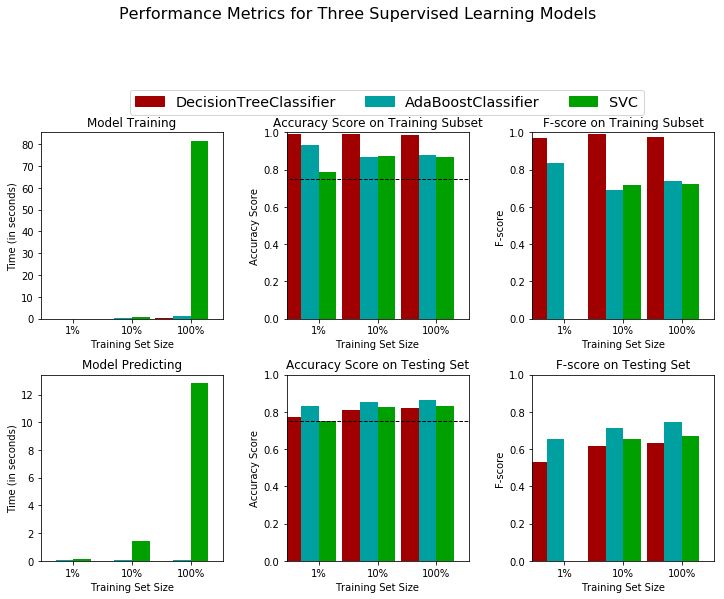

In [85]:
# TODO：从sklearn中导入三个监督学习模型
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

# TODO：初始化三个模型
clf_A = DecisionTreeClassifier(random_state=10)
clf_B = AdaBoostClassifier(random_state=20)
clf_C = SVC(random_state=30)

# TODO：计算1%， 10%， 100%的训练数据分别对应多少点
train_len = X_train.shape[0]
samples_1 = int(0.01 * train_len)
samples_10 = int(0.1 * train_len)
samples_100 = train_len

# 收集学习器的结果
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_val, y_val)

# 对选择的三个模型得到的评价结果进行可视化
vs.evaluate(results, accuracy, fscore)

----
## 提高效果

在这最后一节中，您将从三个有监督的学习模型中选择 *最好的* 模型来使用学生数据。你将在整个训练集（`X_train`和`y_train`）上使用网格搜索优化至少调节一个参数以获得一个比没有调节之前更好的 F-score。

### 问题 3 - 选择最佳的模型

*基于你前面做的评价，用一到两段话向 *CharityML* 解释这三个模型中哪一个对于判断被调查者的年收入大于 \$50,000 是最合适的。*             
**提示：**你的答案应该包括评价指标，预测/训练时间，以及该算法是否适合这里的数据。

**回答：**
1. 由上面的图可以看到，SVM所使用的训练和预测时间明显比其他两个算法长，并且SVM无论在训练集还是验证集上的准确性和F-score都没有优势，而且在对1%的训练数据中F-score得分为0；
2. 而对于决策树算法，虽然可以在训练集上取得非常好的准确性和F-score，但其在验证集上的表现基本上都不如其他两个算法；
3. 最后观察AdaBoost，它在训练集上的表现与SVM相当，但在验证集上的准确度和F-score都是最好的，并且训练和预测时间开销都很低，因此，对于当前的数据集，AdaBoost是最具有优势的。

### 问题 4 - 用通俗的话解释模型

*用一到两段话，向 *CharityML* 用外行也听得懂的话来解释最终模型是如何工作的。你需要解释所选模型的主要特点。例如，这个模型是怎样被训练的，它又是如何做出预测的。避免使用高级的数学或技术术语，不要使用公式或特定的算法名词。*

### **回答：** 
1. 举例来说，一个从来没有听过击鼓和钢琴发出的声音的人，当他第一次听到击鼓的声音，并被告知这是击鼓产生的声音，在第一次听到钢琴的声音时，被告知这是钢琴发出的声音；之后，此人通过两种声音在音调、响度、音色形成了对这两种不同声音的认知。然后，下一次他听到了某个声音（假设是击鼓或者钢琴产生的）时，他就能够跟去前面获得的认知判断这个声音是击鼓还是钢琴产生的。
2. 这个过程就和我们的模型的工作原理很类似。模型，就是潜在的对于音调、响度、音色与不同乐器的对应关系，譬如：假定音调高、音色清澈、响度较低的声音归类为钢琴发出的声音，而音调低、音色浑浊、响度高的声音归类为击鼓产生的声音；训练模型，就是假设音调、音色、响度确实和乐器类型之间存在某种关系，然后根据听到的声音形成可以作为下一次听到声音时判断乐器的依据，例如，当响度大于500分贝时，判断为击鼓产生的声音，这里的“大于500分贝”就表现了模型被确定（即训练完成）；使用模型进行预测，就是把这个判断标准对下一次听到的声音进行分类。

### 练习：模型调优
调节选择的模型的参数。使用网格搜索（GridSearchCV）来至少调整模型的重要参数（至少调整一个），这个参数至少需尝试3个不同的值。你要使用整个训练集来完成这个过程。在接下来的代码单元中，你需要实现以下功能：

- 导入[`sklearn.model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 和 [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- 初始化你选择的分类器，并将其存储在`clf`中。
 - 设置`random_state` (如果有这个参数)。
- 创建一个对于这个模型你希望调整参数的字典。
 - 例如: parameters = {'parameter' : [list of values]}。
 - **注意：** 如果你的学习器有 `max_features` 参数，请不要调节它！
- 使用`make_scorer`来创建一个`fbeta_score`评分对象（设置$\beta = 0.5$）。
- 在分类器clf上用'scorer'作为评价函数运行网格搜索，并将结果存储在grid_obj中。
- 用训练集（X_train, y_train）训练grid search object,并将结果存储在`grid_fit`中。

**注意：** 取决于你选择的参数列表，下面实现的代码可能需要花一些时间运行！

In [87]:
# TODO：导入'GridSearchCV', 'make_scorer'和其他一些需要的库
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.metrics import make_scorer
from sklearn.naive_bayes import GaussianNB

# TODO：初始化分类器
clf = AdaBoostClassifier(random_state=50)
estimators = [GaussianNB(), DecisionTreeClassifier(max_depth=2, random_state=70)]

# TODO：创建你希望调节的参数列表
parameters = {'n_estimators': [50, 60, 70, 80, 90],
              'base_estimator': estimators}

# TODO：创建一个fbeta_score打分对象
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO：在分类器上使用网格搜索，使用'scorer'作为评价函数
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)

# TODO：用训练数据拟合网格搜索对象并找到最佳参数
grid_obj.fit(X_train, y_train)

# 得到estimator
best_clf = grid_obj.best_estimator_

# 使用没有调优的模型做预测
predictions = (clf.fit(X_train, y_train)).predict(X_val)
best_predictions = best_clf.predict(X_val)

# 汇报调优后的模型
print ("best_clf\n------")
print (best_clf)

# 汇报调参前和调参后的分数
print ("\nUnoptimized model\n------")
print ("Accuracy score on validation data: {:.4f}".format(accuracy_score(y_val, predictions)))
print ("F-score on validation data: {:.4f}".format(fbeta_score(y_val, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the validation data: {:.4f}".format(accuracy_score(y_val, best_predictions)))
print ("Final F-score on the validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5)))

best_clf
------
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=70,
            splitter='best'),
          learning_rate=1.0, n_estimators=60, random_state=50)

Unoptimized model
------
Accuracy score on validation data: 0.8648
F-score on validation data: 0.7443

Optimized Model
------
Final accuracy score on the validation data: 0.8744
Final F-score on the validation data: 0.7618


---

第一次修改
---
Q：

很棒，对Adaboost的预测过程掌握得很不错，但训练过程的小细节需要注意:

- 你还需要知道分类器在`Adaboost`中是如何组合在一起的。比如说:对于分类能力很强的基分类器和分类能力很弱的基分类器，我们是要平等对待还是说按照能力的大小有区别地对待呢？
- 同时，你要知道`Adaboost`是如何对待上一个分类器分类错误的数据
- 你可以从这篇论文 http://cseweb.ucsd.edu/~yfrefund/papers/IntroToBoosting.pdf 了解到更多有关Adaboost的训练细节，你可以仔细研读论文中Adaboost这一小节，其他篇章可以泛读。大概需要15~20分钟的时间你就可以对Adaboost有更深的认识。

对以上几点有所了解后，通过一个故事展现出模型大致的训练过程。

A：
- `Adaboost`是以串行的方式生成每个弱分类器的，每个弱分流器的生成依赖于前一个分类器对训练数据的分类误差；在每次训练中，生成了：1）一个弱分类器$G_i(x)$；2）一个该弱分类器在最终分类器中的权重系数$\alpha_i$；3）一个用于下一轮训练的包含针对每个样本的误差权重的向量$W$；4）一个由若干弱分类器，以$\alpha_i$系数进行重要性划分，通过线性组合而成的最终分类器$f(x)$，（这个最终分类器不一定是理想的，所以如果有必要，就需要进行下一轮训练）；
- 在每一轮计算中，弱分类器的权重系数由公式：$\alpha_i=\frac{1}{2}ln\frac{1-e_i}{e_i}$取得，随着误差$e_i$越来越小，$\alpha_i$会越来越大，意味着分类误差越小的弱分类器拥有越高的预测重要性；
- 当样本的误差权重$W$更新时，被当前弱分类器分类错误的样本，其权重会更大，而分类正确的样本，其权重会越小；

使用`Adaboost`训练模型的过程：假设有一堆人，对地上的一堆地瓜进行分类，在经过讨论之后，这堆人在看到一个新的地瓜时，就可以达成共识，得出这个地瓜是好是坏。这个达成共识的过程就相当于模型训练的过程，在这个过程中，从第一个人开始，第一个人觉得看起来好看的瓜就是好瓜，但是有些瓜不好判断是好看还是不好看，可能介于中间；第二个人决定对第一个人难以判断的瓜进行重点考察，之前难以区分是不是好看的瓜，可以通过敲击的声音刚好区分开，但也有一些通过敲击的声音难以区分的地瓜；第三个人再重点考察前面一个人难以区分的地瓜……；如此迭代下去，最后综合所有参与过这一过程的人的意见，并且谁能够在这堆地瓜上区分得更准确，谁的话事权就越大，这样这些人刚好能把这堆瓜全部正确区分出好坏。这样一个模型就训练完成了，以后再看到地瓜时，大家站在一起，投个票，例如话事权大的人最多可以投10票（好或坏），话事权小的人最多可以投2票（好或坏），就可以判断出瓜的好坏，这就是使用模型预测的过程。

第二次修改：
---

`AdaBoost`的算法步骤：
给定一个二分类的数据集：$T={(x_1, y_1), (x_2,y_2), (x_3, y_3), \dotso, (x_N, y_N)}$
每个样本点由特征向量和对应的标记组合，特征向量$x_i\in\mathcal{X}\subseteq\mathbf{R}^n$，标记$y_i\in\mathcal{Y}={-1,+1}$。其中$\mathcal{X}$是特征空间，$\mathcal{Y}$是标记集合。Adaboost从训练数据中学习一系列弱分类算法/基本分类器，并最终使用权重将这些弱分类器线性组合成一个强分类器。
输入：训练数据集$T$，对应的标签$y_i$，某种弱学习算法（例如决策树）。
输出：最终的分类器$G(x)$。
步骤如下：
1. 初始化训练数据集中每个采样点的误差权重分布（该权重用于改变该采样点在后续处理过程中的重要性）：
$$
D_1=(w_{1,1},w_{1,2},w_{1,3},\dotso,w_{1,N}), w_{1,i}=\frac{1}{N},i=1,2,3,\dotso,N
$$
 $D_1$的下标$1$表示训练的轮数，$D_1$即第一轮
2. 设训练轮数$m=1,2,3,\dotso,M$
 1. 使用权重分布$D_m$对训练数据集$T$进行训练，得到弱分类器：
   $$
   G_m(x):\mathcal{X}\mapsto{-1,+1}
   $$
 2. 计算$G_m(x)$在训练集上的分类误差
   $$
   e_m=\sum_{i=1}^{N}P(G_m(x)\neq y_i)=\sum_{i=1}^{N}w_{m,i}I(G_m(x_i)\neq y_i)
   $$
   上式中的$I(G_m(x_i)\neq y_i)$是指示函数，表示当$G_m(x_i)=y_i$时，$I(x)=1$，否则$I(x)=0$，那么$\sum_{i=1}^{N}w_{m,i}I(G_m(x_i)\neq y_i)$就等于弱分类器在所有错误分类的样本中，对应的误差权重$w_{m,i}$之和。
 3. 计算弱分类器$G_m(x)$在最终输出的强分类器中的权重系数，表示这一弱分类器在最终强分类器中的重要程度：
   $$
   \alpha=\frac{1}{2}ln\frac{1-e_m}{e_m}
   $$
 4. 更新计算出下一轮的弱分类器所需的样本权重：
   $$
   D_{m+1}=(w_{m+1,1},w_{m+1,2},w_{m+1,3},\dotso,w_{m+1,N}) \\
   w_{m+1,i}=\frac{w_{m,i}}{Z_m}e^{-\alpha_{m}y_{i}G_{m}(x_i)}, i=1,2,3,\dotso,N
   $$
   其中，$Z_m$是上一轮权重的归一化因子
   $$
   Z_m=\sum_{i=1}^{N}w_{m,i}e^{-\alpha_{m}y_{i}G_{m}(x)}
   $$
3. 经过$M$轮训练之后，就可以得到$M$个弱分类器，和对应的$M$个权重系数$\alpha_i$，最终的强分类器为：
  $$
  g(x) = sign[f(x)]=sign[\sum_{m=1}^{M}\alpha_{m}G_{m}(x)]
  $$

下面举例说明`Adaboost`训练的过程。
给定下表所示的数据集：

|序号|1|2|3|4|5|6|7|8|9|10|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|$x$|0|1|2|3|4|5|6|7|8|9|
|$y$|1|1|1|-1|-1|-1|1|1|1|-1|

假定弱分类器由下式生成，其中阈值$v$在使得当前弱分类器在训练数据集上的分类误差最小时取得。
  $$
  G_m(x) = \left\{ \begin{array}{rcl}
  1, &  x<v \\
  -1, &  x >v
  \end{array}\right.
  , 或者  G_m(x) = \left\{ \begin{array}{rcl}
  1, &  x>v \\
  -1, &  x<v
  \end{array}\right.
  $$
使用AdaBoost的实现过程：
1. 第一轮，$m=1$
 1. 初始化样本的权重值
   $$
   D_1=(w_{1,1},w_{1,2},w_{1,3},\dotso,w_{1,10}), w_{1,i}=\frac{1}{10}=0.1
   $$
 2. 在权重分布$D_1$的基础上，训练弱分类器，训练结果如下

In [184]:
from collections import defaultdict
from sklearn.metrics import accuracy_score
import numpy as np

weak_classifier_params = []
m = 1

x = np.arange(10)
y = np.array([1,1,1,-1,-1,-1,1,1,1,-1])

def weak_classifier(x, threshold, sign=1):
    '''
    find a weak learner, with which can minimize error
    x, training data
    threshold, algorithm parameter, if x_i > threshold, y_i = sign, else y_i = -sign
    sign, algorithm parameter
    '''
    result = np.zeros(x.shape[0], dtype=int)
    for i, val in enumerate(x):
        if val > threshold:
            result[i] = sign
        else:
            result[i] = -sign
    return result

def calculate_error(real, pred, D):
    '''
    calculate weighted error
    '''
    result = real == pred
    error = 0
    for i, val in enumerate(result):
        if not val:
            error += D[i]
    return error

def find_weak_learner(x, y, D):
    '''
    x, training data
    y, training label
    D, weight distribution in every sample inside x
    '''
    min_weighted_error = 1
    best_threshold = 0
    best_sign = 1
    thresholds = np.arange(12) - 0.5
    for threshold in thresholds:
        for sign in [1, -1]:
            pred = weak_classifier(x, threshold, sign)
            error = calculate_error(y, pred, D)
            if error < min_weighted_error:
                min_weighted_error = error
                best_threshold = threshold
                best_sign = sign
    return min_weighted_error, best_threshold, best_sign

D1 = np.ones(10)/10
min_weighted_error, threshold, sign = find_weak_learner(x, y, D1)

# D1 对应的预测
G1_pred = weak_classifier(x, threshold, sign)
e1 = calculate_error(y, G2_pred, D1)
a1 = 1.0/2*np.log((1-e1)/e1)
Z1 = np.sum(D1 * np.exp(-a1*y*G1_pred))
D2 = D1/Z1*np.exp(-a1*y*G1_pred)
weak_classifier_params.append({'alpha': a1, 'threshold': threshold, 'sign': sign, 'error': min_weighted_error})

print("result sign:{}, threshold:{}, min error:{:0.4f}, a1:{:0.4f}".format(sign,
    threshold, e1, a1))

result sign:-1, threshold:2.5, min error:0.3000, a1:0.4236


1.  2. 由以上结果可以知道，当阈值$v=2.5$时分类误差最小，因此得到弱分类器
  $$
  G_1(x) = \left\{ \begin{array}{rcl}
  1, &  x<2.5 \\
  -1, &  x >2.5
  \end{array}\right.
  $$
  
  3. 由以上结果可以知道，$G_1(x)$在训练集上的训练误差率为$e_1=P(G_i(x_i))\neq y_i)=0.3$
  4. 计算$G_1(x)$的权重系数：$\alpha_1=\frac{1}{2}ln\frac{1-e_1}{e_1}=0.4236$
  5. 更新所有样本点的误差权重分布，用以下一轮训练使用：
    $$
    D_2=(w_{2,1},w_{2,2},w_{2,3},\dotso,w_{2,N}) \\
    w_{2,i}=\frac{w_{1,i}}{Z_1}e^{-\alpha_{1}y_{i}G_{1}(x_i)}
    $$
  6. 第一轮结束后得到的最终分类器为：$g_1(x)=sign[f_1(x)]=sign[0.4236*G1(x)]$

In [185]:
pred = np.zeros(x.shape[0])
for param in weak_classifier_params:
    pred += param['alpha'] * weak_classifier(x, param['threshold'], param['sign'])
pred = np.sign(pred)
final_error = 1 - accuracy_score(y, pred)
print("Predict error in classifier in run m={}: {:.2f},\nresult:{}".format(m, final_error, (pred == y)))

Predict error in classifier in run m=1: 0.30,
result:[ True  True  True  True  True  True False False False  True]


1. 7. 第一轮结束后，最终分类器仍然有0.3的误差，所以需要增加更多弱分类器。

2. 第二轮，$m=2$
 1. 根据前面计算得到的$D_2$，计算出下一个弱分类器


In [186]:
m = 2
min_weighted_error, threshold, sign = find_weak_learner(x, y, D2)

# D2 对应的预测
G2_pred = weak_classifier(x, threshold, sign)
e2 = calculate_error(y, G2_pred, D2)
a2 = 1.0/2*np.log((1-e2)/e2)
Z2 = np.sum(D2 * np.exp(-a2*y*G2_pred))
D3 = D2/Z2*np.exp(-a2*y*G2_pred)
weak_classifier_params.append({'alpha': a2, 'threshold': threshold, 'sign': sign, 'error': min_weighted_error})

print("result sign:{}, threshold:{}, min error:{:0.4f}, a2:{:0.4f}".format(sign,
    threshold, min_weighted_error, a2))

result sign:-1, threshold:8.5, min error:0.2143, a2:0.6496


2.  2. 由以上结果可以知道，当阈值$v=8.5$时分类误差最小，因此得到弱分类器
  $$
  G_2(x) = \left\{ \begin{array}{rcl}
  1, &  x<8.5 \\
  -1, &  x >8.5
  \end{array}\right.
  $$
  
  3. 由以上结果可以知道，$G_2(x)$在训练集上的训练误差率为$e_2=P(G_2(x_i))\neq y_i)=0.2143$
  4. 计算$G_2(x)$的权重系数：$\alpha_2=\frac{1}{2}ln\frac{1-e_2}{e_2}=0.6496$
  5. 更新所有样本点的误差权重分布，用以下一轮训练使用：
    $$
    D_3=(w_{3,1},w_{3,2},w_{3,3},\dotso,w_{3,N}) \\
    w_{3,i}=\frac{w_{2,i}}{Z_2}e^{-\alpha_{2}y_{i}G_{2}(x_i)}
    $$
  6. 第一轮结束后得到的最终分类器为：$g_2(x)=sign[f_2(x)]=sign[0.4236*G_1(x)+0.6496*G_2(x)]$

In [187]:
pred = np.zeros(x.shape[0])
for param in weak_classifier_params:
    pred += param['alpha'] * weak_classifier(x, param['threshold'], param['sign'])
pred = np.sign(pred)
final_error = 1 - accuracy_score(y, pred)
print("Predict error in classifier in run m={}: {:.2f},\nresult:{}".format(m, final_error, (pred == y)))

Predict error in classifier in run m=2: 0.30,
result:[ True  True  True False False False  True  True  True  True]


2. 7. 第二轮结束后，最终分类器仍然有0.3的误差，所以需要增加更多弱分类器。


3. 第三轮，$m=3$
 1. 根据前面计算得到的$D_3$，计算出下一个弱分类器

In [188]:
m = 3
min_weighted_error, threshold, sign = find_weak_learner(x, y, D3)

# D3 对应的预测
G3_pred = weak_classifier(x, threshold, sign)
e3 = calculate_error(y, G3_pred, D3)
a3 = 1.0/2*np.log((1-e3)/e3)
Z3 = np.sum(D3 * np.exp(-a3*y*G3_pred))
D4 = D3/Z3*np.exp(-a3*y*G3_pred)
weak_classifier_params.append({'alpha': a3, 'threshold': threshold, 'sign': sign, 'error': min_weighted_error})

print("result sign:{}, threshold:{}, min error:{:0.4f}, a3:{:0.4f}".format(sign,
    threshold, min_weighted_error, a3))

result sign:1, threshold:5.5, min error:0.1818, a3:0.7520


3.  2. 由以上结果可以知道，当阈值$v=5.5$时分类误差最小，因此得到弱分类器
  $$
  G_3(x) = \left\{ \begin{array}{rcl}
  1, &  x>5.5 \\
  -1, &  x<5.5
  \end{array}\right.
  $$
  
  3. 由以上结果可以知道，$G_3(x)$在训练集上的训练误差率为$e_3=P(G_3(x_i))\neq y_i)=0.1818$
  4. 计算$G_3(x)$的权重系数：$\alpha_3=\frac{1}{2}ln\frac{1-e_3}{e_3}=0.7520$
  5. 更新所有样本点的误差权重分布，用以下一轮训练使用：
    $$
    D_4=(w_{4,1},w_{4,2},w_{4,3},\dotso,w_{4,N}) \\
    w_{4,i}=\frac{w_{3,i}}{Z_3}e^{-\alpha_{3}y_{i}G_{3}(x_i)}
    $$
  6. 第一轮结束后得到的最终分类器为：$g_3(x)=sign[f_3(x)]=sign[0.4236*G_1(x)+0.6496*G_2(x)+0.7520*G_3(x)]$

In [189]:
pred = np.zeros(x.shape[0])
for param in weak_classifier_params:
    pred += param['alpha'] * weak_classifier(x, param['threshold'], param['sign'])
pred = np.sign(pred)
final_error = 1 - accuracy_score(y, pred)
print("Predict error in classifier in run m={}: {:.2f},\nresult:{}".format(m, final_error, (pred == y)))

Predict error in classifier in run m=3: 0.00,
result:[ True  True  True  True  True  True  True  True  True  True]


3. 7. 此时，最终分类器$g_3(x)$在训练集上的误差为0，不需要再添加新的弱分类器，结束计算。


> 参考：《统计学习方法》，李航，第8章

___

### 问题 5 - 最终模型评估

_你的最优模型在测试数据上的准确率和 F-score 是多少？这些分数比没有优化的模型好还是差？_
**注意：**请在下面的表格中填写你的结果，然后在答案框中提供讨论。

#### 结果:
 
| 评价指标         |  未优化的模型        | 优化的模型        |
| :------------: |  :---------------: | :-------------: | 
| 准确率          |          0.8648    |     0.8744     |
| F-score        |          0.7443     |    0.7618       |

**回答：** 可以看到，经过参数优化后，模型的准确率和F-score都有所提升，但幅度不大。

----
## 特征的重要性

在数据上（比如我们这里使用的人口普查的数据）使用监督学习算法的一个重要的任务是决定哪些特征能够提供最强的预测能力。专注于少量的有效特征和标签之间的关系，我们能够更加简单地理解这些现象，这在很多情况下都是十分有用的。在这个项目的情境下这表示我们希望选择一小部分特征，这些特征能够在预测被调查者是否年收入大于\$50,000这个问题上有很强的预测能力。

选择一个有 `'feature_importance_'` 属性的scikit学习分类器（例如 AdaBoost，随机森林）。`'feature_importance_'` 属性是对特征的重要性排序的函数。在下一个代码单元中用这个分类器拟合训练集数据并使用这个属性来决定人口普查数据中最重要的5个特征。

### 问题 6 - 观察特征相关性

当**探索数据**的时候，它显示在这个人口普查数据集中每一条记录我们有十三个可用的特征。             
_在这十三个记录中，你认为哪五个特征对于预测是最重要的，选择每个特征的理由是什么？你会怎样对他们排序？_

**回答：**
- 特征1: capital-gain，资本收益，直接反映个人的财富稳定性，是否增长；
- 特征2: capital-loss，资本损失，和资本收益相关，反映个人财富的变化；
- 特征3: age，通常情况下，年龄小的人不大可能积累较多的财富；
- 特征4: education-level，受教育程度高的人往往积累的知识更多，也更加聪明，能够靠智慧获取更多财富；
- 特征5: education_num，与education-level类似，越大，意味着积累的知识越多，属于稀缺人才，能够积累更多财富。

按照重要性从高到低排序：

- capital-loss，与财富有直接关系，了解资本损失可能比了解资本增益更重要；
- capital-gain，与财富有直接关系；
- age，对于每个人来说，年龄越大，财富积累越多，这应该是一种普适的生活状态，所以准确性应该很高；
- education-level和education_num重要性相当

### 练习 - 提取特征重要性

选择一个`scikit-learn`中有`feature_importance_`属性的监督学习分类器，这个属性是一个在做预测的时候根据所选择的算法来对特征重要性进行排序的功能。

在下面的代码单元中，你将要实现以下功能：
 - 如果这个模型和你前面使用的三个模型不一样的话从sklearn中导入一个监督学习模型。
 - 在整个训练集上训练一个监督学习模型。
 - 使用模型中的 `'feature_importances_'`提取特征的重要性。

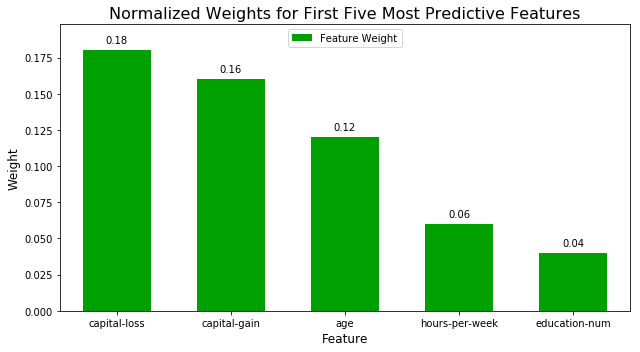

In [88]:
# TODO：导入一个有'feature_importances_'的监督学习模型

# TODO：在训练集上训练一个监督学习模型
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# TODO： 提取特征重要性
importances = model.feature_importances_

# 绘图
vs.feature_plot(importances, X_train, y_train)

### 问题 7 - 提取特征重要性
观察上面创建的展示五个用于预测被调查者年收入是否大于\$50,000最相关的特征的可视化图像。

_这五个特征的权重加起来是否超过了0.5?_<br>
_这五个特征和你在**问题 6**中讨论的特征比较怎么样？_<br>
_如果说你的答案和这里的相近，那么这个可视化怎样佐证了你的想法？_<br>
_如果你的选择不相近，那么为什么你觉得这些特征更加相关？_

**回答：**
1. 这五个特征的权重加起来为0.56，超过0.5；
2. hours-per-week没有在我的预期内；
3. capital-loss和capital-gain和个人财富是直接相关的，所以其影响比重确实应该排在前面；通常，年龄越大越有可能积累财富；education-num和education-level都表示着受教育程度，即知识的积累程度，两者应该有相近的影响权重。

### 特征选择

如果我们只是用可用特征的一个子集的话模型表现会怎么样？通过使用更少的特征来训练，在评价指标的角度来看我们的期望是训练和预测的时间会更少。从上面的可视化来看，我们可以看到前五个最重要的特征贡献了数据中**所有**特征中超过一半的重要性。这提示我们可以尝试去**减小特征空间**，简化模型需要学习的信息。下面代码单元将使用你前面发现的优化模型，并**只使用五个最重要的特征**在相同的训练集上训练模型。

In [89]:
# 导入克隆模型的功能
from sklearn.base import clone

# 减小特征空间
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_val_reduced = X_val[X_val.columns.values[(np.argsort(importances)[::-1])[:5]]]

# 在前面的网格搜索的基础上训练一个“最好的”模型
clf_on_reduced = (clone(best_clf)).fit(X_train_reduced, y_train)

# 做一个新的预测
reduced_predictions = clf_on_reduced.predict(X_val_reduced)

# 对于每一个版本的数据汇报最终模型的分数
print ("Final Model trained on full data\n------")
print ("Accuracy on validation data: {:.4f}".format(accuracy_score(y_val, best_predictions)))
print ("F-score on validation data: {:.4f}".format(fbeta_score(y_val, best_predictions, beta = 0.5)))
print ("\nFinal Model trained on reduced data\n------")
print ("Accuracy on validation data: {:.4f}".format(accuracy_score(y_val, reduced_predictions)))
print ("F-score on validation data: {:.4f}".format(fbeta_score(y_val, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on validation data: 0.8744
F-score on validation data: 0.7618

Final Model trained on reduced data
------
Accuracy on validation data: 0.8485
F-score on validation data: 0.7213


### 问题 8 - 特征选择的影响

*最终模型在只是用五个特征的数据上和使用所有的特征数据上的 F-score 和准确率相比怎么样？*  
*如果训练时间是一个要考虑的因素，你会考虑使用部分特征的数据作为你的训练集吗？*

**回答：**从以上数据可以看到，最终模型在只是使用五个主要特征的数据上所得的F-score和准确率和使用所有特征的数据所得的F-score和准确率相差不远，而且事实上，使用五个主要特征的数据训练时间也要少很多。所以，如果训练时间是一个要考虑的因素，是有充分的理由只使用主要特征的数据作为训练集的。

### 问题 9 - 在测试集上测试你的模型

终于到了测试的时候，记住，测试集只能用一次。

*使用你最有信心的模型，在测试集上测试，计算出准确率和 F-score。*
*简述你选择这个模型的原因，并分析测试结果*

In [90]:
#TODO test your model on testing data and report accuracy and F score
test_pred = best_clf.predict(X_test)
print("Accuracy on test data:{:.4f}".format(accuracy_score(y_test, test_pred)))
print("F-score on test data:{:.4f}".format(fbeta_score(y_test, test_pred, beta=0.5)))

Accuracy on test data:0.8674
F-score on test data:0.7510


> **注意：** 当你写完了所有的代码，并且回答了所有的问题。你就可以把你的 iPython Notebook 导出成 HTML 文件。你可以在菜单栏，这样导出**File -> Download as -> HTML (.html)**把这个 HTML 和这个 iPython notebook 一起做为你的作业提交。